In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
torch.backends.cudnn.benchmark=True
import time

from adamw import AdamW
from scheduler import Scheduler, LRScheduler
from models import *

import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel

import argparse

In [3]:
PATH = Path('../data')
# PATH = Path('/ncluster/models/resnet_test.pth')
MODEL_PATH = Path('/ncluster/models')
MODEL_PATH.mkdir(exist_ok=True)
save_tag = 'resnet_test'

In [6]:
# Parsing
def get_parser():
    parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
#     parser.add_argument('data', metavar='DIR', help='path to dataset')
    parser.add_argument('--phases', type=str, help='Learning rate schedule')
    parser.add_argument('-j', '--workers', default=8, type=int, help='number of data loading workers (default: 8)')
    parser.add_argument('--start-epoch', default=0, type=int, help='manual epoch number (useful on restarts)')
    parser.add_argument('--momentum', default=0.9, type=float, help='momentum')
    parser.add_argument('--print-freq', '-p', default=5, type=int, help='print every')
    parser.add_argument('--dist-url', default='env://', type=str, help='url used to set up distributed training')
    parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')
    parser.add_argument('--local_rank', default=0, type=int, help='Used for multi-process training')
    return parser

# Distributed
def reduce_tensor(tensor): return sum_tensor(tensor)/env_world_size()
def sum_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    return rt
def env_world_size(): return int(os.environ.get('WORLD_SIZE', 1))
def env_rank(): return int(os.environ.get('RANK',0))

args = get_parser().parse_args([])

In [8]:
is_distributed = env_world_size() > 1
if args.local_rank > 0:
    f = open('/dev/null', 'w')
    sys.stdout = f
    
if is_distributed:
    print('Distributed initializing process group')
    torch.cuda.set_device(args.local_rank)
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url, world_size=env_world_size())
    assert(env_world_size() == dist.get_world_size())
    print("Distributed: success (%d/%d)"%(args.local_rank, dist.get_world_size()))


In [11]:
# IMAGENET_PATH = PATH/'imagenet-sz/320/train'
# train_ds = ImageClassificationDataset.from_folder(IMAGENET_PATH)
COCO_PATH = PATH/'coco/resize'
train_ds = ImageClassificationDataset.from_folder(COCO_PATH)

# size,bs = 96,36
# size,bs = 128,32
size,bs = 256,20

# Content Data
data_norm,data_denorm = normalize_funcs(*imagenet_stats)
train_tds = DatasetTfm(train_ds, tfms=[crop_pad(size=size, is_random=False)], tfm_y=False, size=size, do_crop=True)

data_sampler = DistributedSampler(train_tds, num_replicas=env_world_size(), rank=env_rank()) if is_distributed else None
train_dl = DeviceDataLoader.create(train_tds, tfms=data_norm, num_workers=8, bs=bs, shuffle=(data_sampler is None), sampler=data_sampler)

# Style Data

STYLE_PATH = PATH/'style/dtd/images'
# STYLE_PATH = PATH/'style/dtd/subset'
style_ds = ImageClassificationDataset.from_folder(STYLE_PATH)

# STYLE_PATH = PATH/'style/pbn/train'
# style_ds = ImageClassificationDataset.from_single_folder(STYLE_PATH, ['train'])

style_tds = DatasetTfm(style_ds, tfms=[crop_pad(size=size, is_random=False)], tfm_y=False, size=size, do_crop=True)
style_dl = DeviceDataLoader.create(style_tds, tfms=data_norm, num_workers=8, bs=1, shuffle=True)

### Loss

In [12]:
# Loss Functions
# losses
def ct_loss(input, target): return F.mse_loss(input,target)

def gram(input):
        b,c,h,w = input.size()
        x = input.view(b, c, -1)
        return torch.bmm(x, x.transpose(1,2))/(c*h*w)

def gram_loss(input, target): return F.mse_loss(gram(input), gram(target))

def tva_loss(y):
    w_var = torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:]))
    h_var = torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))
    return w_var + h_var


### Distributed

In [13]:
from torch.utils.data.distributed import DistributedSampler

def reduce_tensor(tensor): return sum_tensor(tensor)/env_world_size()
def sum_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    return rt

def env_world_size(): return int(os.environ.get('WORLD_SIZE', 1))
def env_rank(): return int(os.environ.get('RANK',0))

In [14]:
# losses
def ct_loss(input, target): return F.mse_loss(input,target)

def gram(input):
        b,c,h,w = input.size()
        x = input.view(b, c, -1)
        return torch.bmm(x, x.transpose(1,2))/(c*h*w)

def gram_loss(input, target): return F.mse_loss(gram(input), gram(target))

def tva_loss(y):
    w_var = torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:]))
    h_var = torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))
    return w_var + h_var

## Create models

In [15]:
# Create models
mt = StyleTransformer()
ms = StylePredict.create_resnet()
# ms = StylePredict.create_inception()
m_com = CombinedModel(mt, ms).cuda()

In [16]:
m_vgg = VGGActivations().cuda()

if is_distributed: 
    m_com = DistributedDataParallel(m_com, device_ids=[args.local_rank], output_device=args.local_rank)
    m_vgg = DistributedDataParallel(m_vgg, device_ids=[args.local_rank], output_device=args.local_rank)
    
    

Layer ids:  [12, 22, 32, 42]


### Set params

In [17]:
epochs = 3
log_interval = 50
optimizer = AdamW(m_com.parameters(), lr=1e-5, betas=(0.9,0.999), weight_decay=1e-3)

In [18]:
lr_mult = env_world_size()
scheduler = LRScheduler(optimizer, [{'ep': (0,1),      'lr': (1e-5*lr_mult,5e-4*lr_mult)}, 
                                  {'ep': (1,2),      'lr': (5e-4*lr_mult,1e-5*lr_mult)},
                                  {'ep': (2,epochs), 'lr': (1e-5*lr_mult,1e-7*lr_mult)}])

In [19]:
style_wgts = [i*1e9 for i in [5,50,5,.5]] # 2,3,4,5
c_block = 1 # 1=3
ct_wgt = 1e3
tva_wgt = 5e-6

In [20]:
# m_com.load_state_dict(torch.load(MODEL_PATH/f'model_combined_4_imagenet_256.pth'), strict=False)
m_com.load_state_dict(torch.load(MODEL_PATH/f'{save_tag}.pth'), strict=True)

In [23]:

start = time.time()
m_com.train()
style_image_count = 0
for e in range(epochs):
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_tva_loss = 0.
    count = 0
    batch_tot = len(train_dl)
    for batch_id, (x_con,_) in enumerate(train_dl):
        scheduler.update_lr(e, batch_id, batch_tot)
        
#         if (batch_id % (log_interval*3) == 0):
        try:
            x_style,_ = next(it_style)
            style_image_count += 1
        except:
            it_style = iter(style_dl)
            x_style,_ = next(it_style)
            print('Restarting style')
            style_image_count = 1
            
        with torch.no_grad(): 
            style_batch = x_style.repeat(bs,1,1,1)
            s_out = m_vgg(style_batch)
            style_feat = [s.clone() for s in s_out]
            
            targ_feat = m_vgg(x_con)[c_block].clone()
            
        n_batch = x_con.size(0)
        count += n_batch
        optimizer.zero_grad()
        
        out = m_com(x_con, x_style)
        out,_ = data_norm((out,None))
        inp_feat = m_vgg(out)
        
        closs = [ct_loss(inp_feat[c_block],targ_feat) * ct_wgt]
        sloss = [gram_loss(inp,targ)*wgt for inp,targ,wgt in zip(inp_feat, style_feat, style_wgts) if wgt > 0]
        tvaloss = tva_loss(out) * tva_wgt
        
        total_loss = closs + sloss + [tvaloss]
        total_loss = sum(total_loss)
    
        total_loss.backward()
#         nn.utils.clip_grad_norm_(m_com.m_tran.parameters(), 10)
#         nn.utils.clip_grad_norm_(m_com.m_style.parameters(), 80)
        optimizer.step()
    
        mom = 0.9
        agg_content_loss = agg_content_loss*mom + sum(closs).detach().data*(1-mom)
        agg_style_loss = agg_style_loss*mom + sum(sloss).detach().data*(1-mom)
        agg_tva_loss = agg_tva_loss*mom + tvaloss.detach().data*(1-mom)
        agg_total_loss = (agg_content_loss + agg_style_loss + agg_tva_loss)
        
        if (batch_id + 1) % log_interval == 0:
            time_elapsed = (time.time() - start)/60
            b_tot = len(train_dl)
            mesg = (f"MIN:{time_elapsed:.2f}\tEP[{e+1}]\tB[{batch_id+1:4}/{b_tot}]\t"
                    f"CON:{agg_content_loss:.3f}\tSTYL:{agg_style_loss:.2f}\t"
                    f"TVA:{agg_tva_loss:.2f}\tTOT:{agg_total_loss:.2f}\t"
#                     f"S/CT:{style_image_count:3}/{count:3}"
                   )
            print(mesg)

Restarting style
Changing LR from 1e-05 to 1.001223867922172e-05
MIN:0.13	EP[1]	B[  50/40037]	CON:21.398	STYL:137.57	TVA:1.91	TOT:160.88	S/CT:  50/  1600
MIN:0.25	EP[1]	B[ 100/40037]	CON:21.591	STYL:104.69	TVA:1.99	TOT:128.27	S/CT: 100/  3200
MIN:0.36	EP[1]	B[ 150/40037]	CON:21.595	STYL:130.13	TVA:2.04	TOT:153.76	S/CT: 150/  4800
MIN:0.48	EP[1]	B[ 200/40037]	CON:21.352	STYL:91.91	TVA:2.07	TOT:115.34	S/CT: 200/  6400
MIN:0.59	EP[1]	B[ 250/40037]	CON:21.347	STYL:91.58	TVA:2.07	TOT:114.99	S/CT: 250/  8000
MIN:0.71	EP[1]	B[ 300/40037]	CON:21.518	STYL:174.42	TVA:2.03	TOT:197.97	S/CT: 300/  9600
MIN:0.83	EP[1]	B[ 350/40037]	CON:21.687	STYL:117.53	TVA:2.31	TOT:141.52	S/CT: 350/ 11200
MIN:0.94	EP[1]	B[ 400/40037]	CON:21.838	STYL:95.26	TVA:2.23	TOT:119.33	S/CT: 400/ 12800
MIN:1.06	EP[1]	B[ 450/40037]	CON:21.715	STYL:162.81	TVA:2.46	TOT:186.99	S/CT: 450/ 14400
Restarting style
MIN:1.18	EP[1]	B[ 500/40037]	CON:21.883	STYL:135.18	TVA:2.31	TOT:159.38	S/CT:  20/ 16000
MIN:1.30	EP[1]	B[ 550/40037]	CO

KeyboardInterrupt: 

In [ ]:
def eval_imgs(x_con, x_style, idx=0):
    with torch.no_grad(): 
        out = m_com(x_con, x_style)
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    Image(data_denorm(x_con[idx].cpu())).show(axs[0])
    axs[0].set_title('Content')
    axs[1].set_title('Style')
    axs[2].set_title('Transfer')
    Image(data_denorm(x_style[0].cpu())).show(axs[1])
    Image((out[idx].detach().cpu())).show(axs[2])
    

In [ ]:
x_con,_ = next(iter(train_dl))
idx=0

In [ ]:
x_style,_ = next(iter(style_dl))
eval_imgs(x_con, x_style, idx)

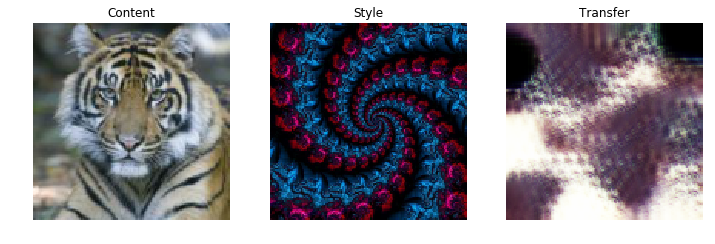

In [66]:
x_style,_ = next(iter(style_dl))
eval_imgs(x_con, x_style, idx)